<a href="https://colab.research.google.com/github/carwilfer/Projeto-IoT-e-Data-Science/blob/main/Code/Model/Experiment%25201/AM_PB_IOT_TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
!pip install pmdarima

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from sklearn.metrics import mean_squared_error, r2_score
from fbprophet import Prophet

In [274]:
df_kill_fem = pd.read_csv('df_kill_fem.csv')
df_kill_fem

,CRASH_DATE,Unnamed: 0,PERSON_INJURY,PERSON_SEX,PERSON_AGE
0,2021-01-01,0,Injured,F,38.725000
1,2021-01-01,2,Killed,F,60.000000
2,2021-01-02,4,Injured,F,35.605263
3,2021-01-03,7,Injured,F,33.489362
4,2021-01-04,9,Injured,F,41.075000
...,...,...,...,...,...
374,2021-11-13,823,Injured,F,35.169492
375,2021-11-14,825,Injured,F,38.041667
376,2021-11-14,827,Killed,F,56.000000
377,2021-11-15,829,Injured,F,40.226415


In [275]:
df_kill_fem['CRASH_DATE'] = pd.to_datetime(df_kill_fem.CRASH_DATE)
df_kill_fem.set_index('CRASH_DATE', inplace=True)

In [294]:
df_kill_fem

,Unnamed: 0,PERSON_INJURY,PERSON_SEX,PERSON_AGE
CRASH_DATE,,,,
2021-01-01,0,Injured,F,38.725000
2021-01-01,2,Killed,F,60.000000
2021-01-02,4,Injured,F,35.605263
2021-01-03,7,Injured,F,33.489362
2021-01-04,9,Injured,F,41.075000
...,...,...,...,...
2021-11-13,823,Injured,F,35.169492
2021-11-14,825,Injured,F,38.041667
2021-11-14,827,Killed,F,56.000000


In [276]:
#df_kill_fem.to_csv('df_kill_fem.csv')

In [277]:
df_kill_fem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 379 entries, 2021-01-01 to 2021-11-16
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     379 non-null    int64  
 1   PERSON_INJURY  379 non-null    object 
 2   PERSON_SEX     379 non-null    object 
 3   PERSON_AGE     379 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 14.8+ KB


In [301]:
df_NYC_janela = pd.DataFrame(df_kill_fem.resample('W')['PERSON_AGE'].count())


In [302]:
adf = ADFTest()
adf.is_stationary(df_NYC_janela)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.



(0.06798550256403402, True)

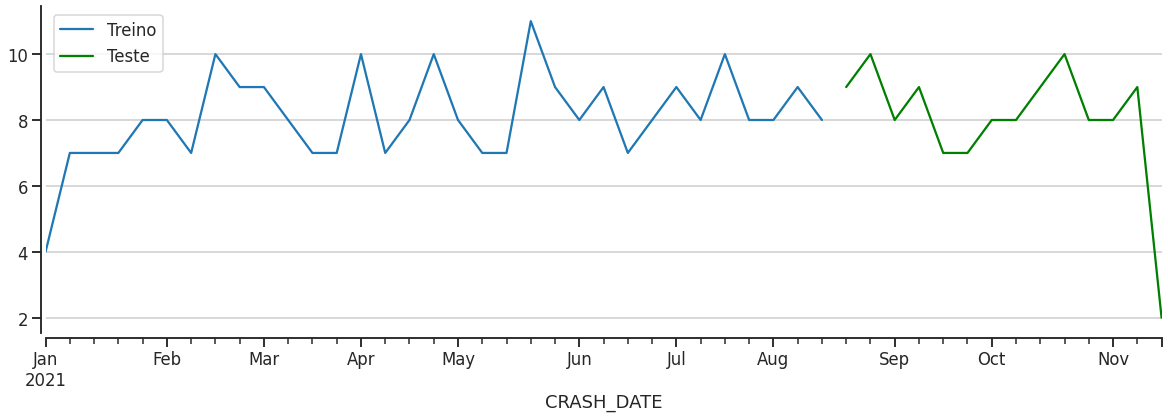

In [303]:
size_of_train = int(np.ceil(df_NYC_janela.shape[0] * 0.70))
train = df_NYC_janela.iloc[:size_of_train]
test = df_NYC_janela.iloc[size_of_train:]

fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [304]:
model = auto_arima(train,
                   start_p=1,
                   start_q=1,
                   max_p=8,
                   max_q=8,
                   m=12,
                   d=1,
                   D=1,
                   seasonal=True,
                   stepwise=False,
                   random_state=20,
                   n_fits=30)

In [305]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -36.927
Date:                             Fri, 01 Apr 2022   AIC                             79.854
Time:                                     02:52:57   BIC                             82.841
Sample:                                          0   HQIC                            80.437
                                              - 33                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6465      0.170     -3.810      0.000      -0.979      -0.314
ar.S.L12      -0.7569      0.193     -3.930      0.000      -1.134      -0.379
sigma2         1.3729      0.939      1.462      0.144      -0.468       3.214
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.20   Prob(JB):                         0.84
Heteroskedasticity (H):               0.75   Skew:                             0.08
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [306]:
model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [307]:
y_predict = model.predict(n_periods = len(test))

In [308]:
y_predict_df = pd.Series(y_predict, index=test.index)
y_predict_df

CRASH_DATE
2021-08-22     8.798839
2021-08-29     7.798839
2021-09-05     7.285019
2021-09-12     6.798839
2021-09-19     9.312659
2021-09-26     7.285019
2021-10-03     7.798839
2021-10-10     9.798839
2021-10-17     7.798839
2021-10-24     7.041929
2021-10-31     7.285019
2021-11-07    10.069569
2021-11-14     8.749939
2021-11-21     7.749939
Freq: W-SUN, dtype: float64

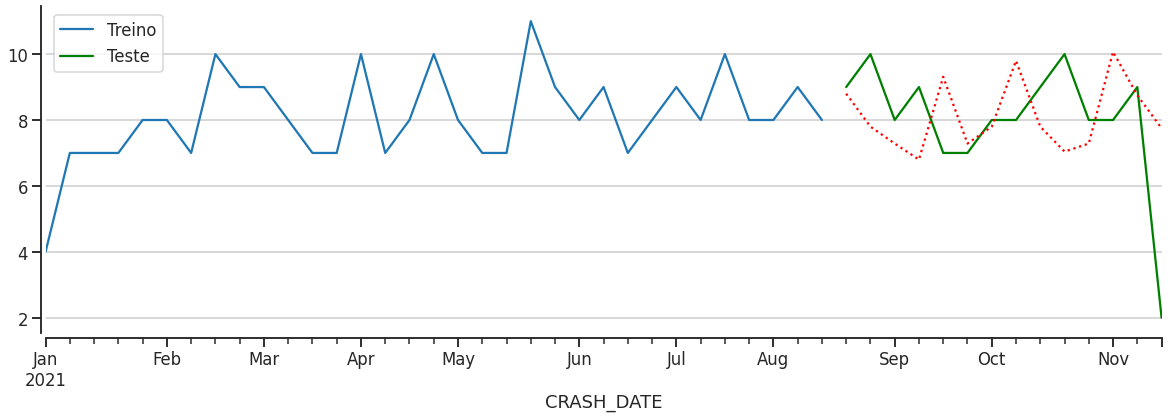

In [309]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
y_predict_df.plot(ax=ax, c="r", ls=":")

ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [310]:
print("R2 Score: ", r2_score(test, y_predict_df[test.index]))
print("MSE: ", mean_squared_error(test, y_predict_df))
print("RMSE: ", mean_squared_error(test, y_predict_df, squared=False))

R2 Score:  -0.3411882241249884
MSE:  4.78995794330353
RMSE:  2.1885972547052894


In [313]:
train_prophet = train.reset_index().rename(columns={'CRASH_DATE': 'ds', 'PERSON_AGE': 'y'})
train_prophet.head()

,ds,y
0,2021-01-03,4
1,2021-01-10,7
2,2021-01-17,7
3,2021-01-24,7
4,2021-01-31,8


In [314]:
model = Prophet()
model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [316]:
periods = df_NYC_janela.shape[0] - size_of_train
future = model.make_future_dataframe(periods=periods, freq="W")
forecast = model.predict(future)

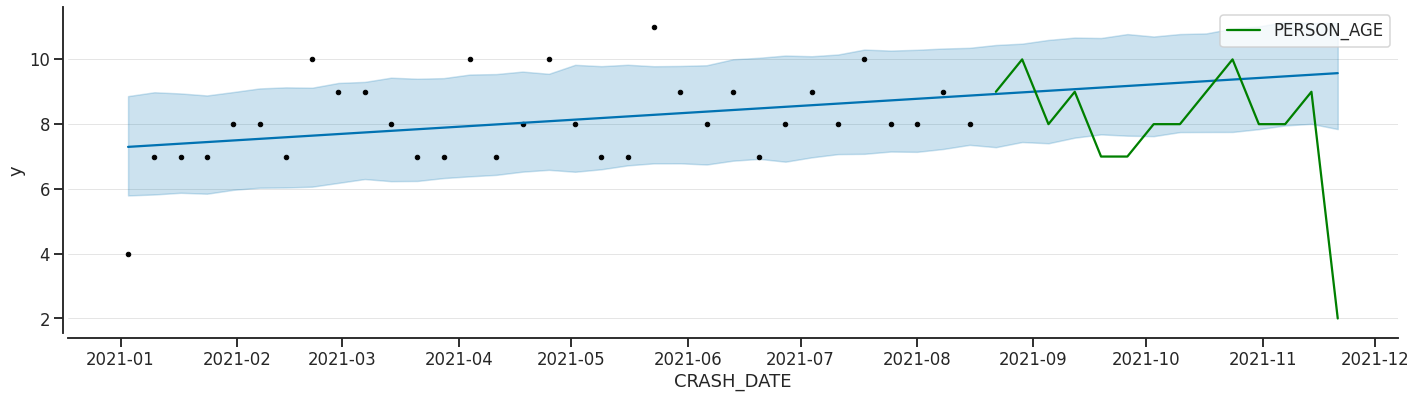

In [317]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [318]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -0.5381330512685607
MSE:  5.493332325959146
RMSE:  2.343785895929734


In [319]:
model = Prophet(yearly_seasonality=1, seasonality_mode="multiplicative")
model.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

In [320]:
future = model.make_future_dataframe(periods=periods, freq="W")
forecast = model.predict(future)

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



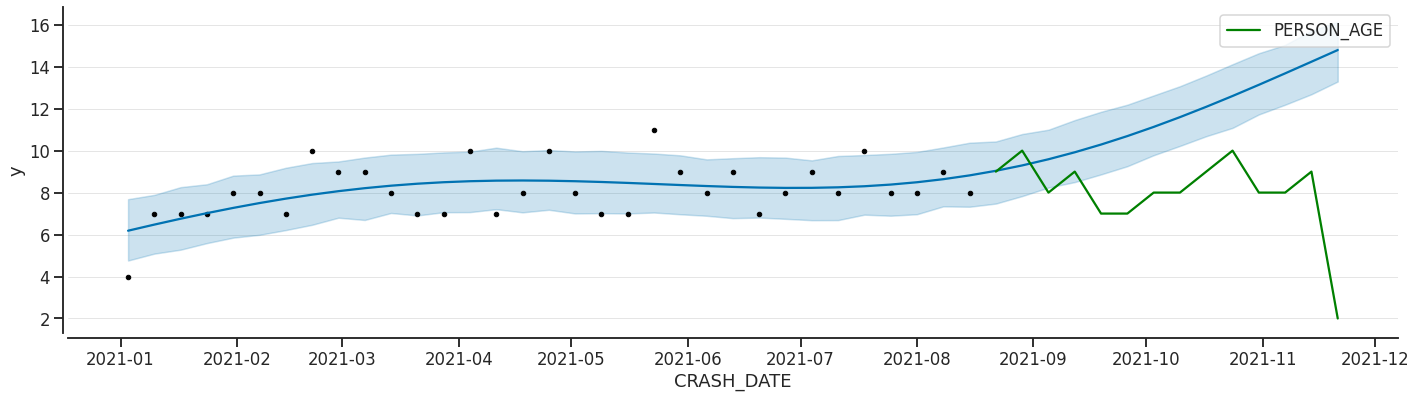

In [321]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [322]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -5.344178873915196
MSE:  22.65778169255427
RMSE:  4.760019085314077


In [323]:
far_future = model.make_future_dataframe(periods=3 * periods, freq="W")
far_forecast = model.predict(far_future)

/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



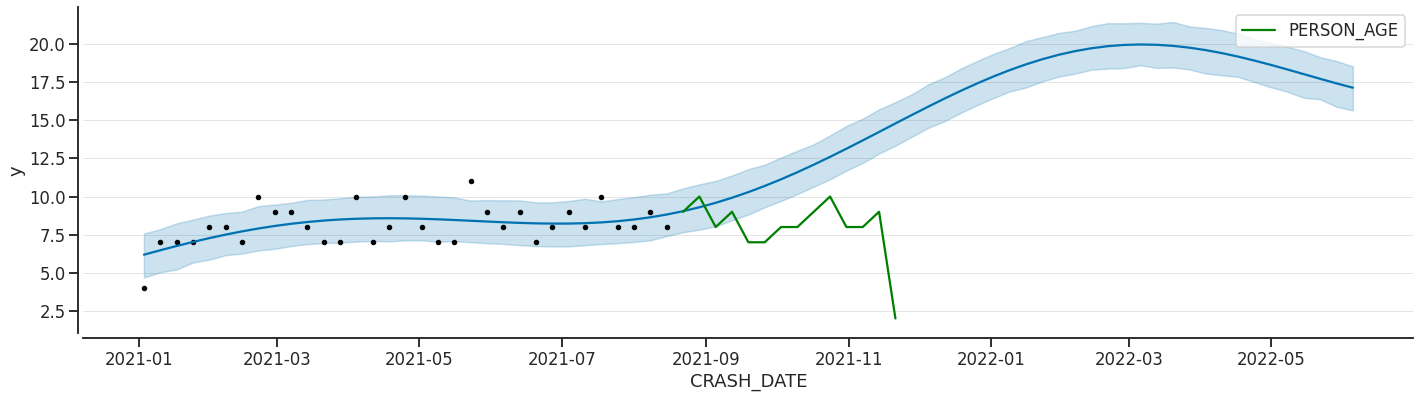

In [324]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(far_forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [325]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  -5.344178873915196
MSE:  22.65778169255427
RMSE:  4.760019085314077
